In [1]:
#importing packages
import cv2
import numpy as np
from sklearn import cluster
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#ClassificationOne.jpg

In [3]:
path = 'ClassificationTwoDices.jpg'

In [4]:
frame = cv2.imread(path)

In [5]:
# Here is the part where we identify individual blobs on each dice
params = cv2.SimpleBlobDetector_Params() # Here is a special method that exists already in Open CV, we need to change parametrs

params.filterByInertia # inertia means how much circular our blob is, the parametr of 1 means a perfect circle
params.minInertiaRatio = 0.6# 0.6 is very similar to the shape of a blob in the dice, hence a correct parametr

detector = cv2.SimpleBlobDetector_create(params)

def get_blobs(frame):# function to detect blurs
    frame_blurred = cv2.medianBlur(frame, 7)
    frame_gray = cv2.cvtColor(frame_blurred, cv2.COLOR_BGR2GRAY)
    blobs = detector.detect(frame_gray)

    return blobs

In [6]:
def get_dice_from_blobs(blobs):# here is a function to detect individual dice
    # Get centroids of all blobs
    X = []
    for b in blobs:
        pos = b.pt# getting the positions on a image of 

        if pos != None:
            X.append(pos) 

    X = np.asarray(X)

    if len(X) > 0:
        # Important to set min_sample to 0, as a dice may only have one dot
        clustering = cluster.DBSCAN(eps=40, min_samples=0).fit(X)

        # Find the largest label assigned + 1, that's the number of dice found
        num_dice = max(clustering.labels_) + 1

        dice = []

        # Calculate centroid of each dice, the average between all a dice's dots
        for i in range(num_dice):
            X_dice = X[clustering.labels_ == i]

            centroid_dice = np.mean(X_dice, axis=0)

            dice.append([len(X_dice), *centroid_dice])

        return dice

    else:
        return []

In [7]:
def overlay_info(frame, dice, blobs): #function to display progress so far
    # Overlay blobs
    for b in blobs:
        pos = b.pt
        r = b.size / 2

        cv2.circle(frame, (int(pos[0]), int(pos[1])),
                   int(r), (255, 0, 0), 2)

    # Overlay dice number
    for d in dice:
        # Get textsize for text centering
        textsize = cv2.getTextSize(
            str(d[0]), cv2.FONT_HERSHEY_PLAIN, 3, 2)[0]

        cv2.putText(frame, str(d[0]),
                    (int(d[1] - textsize[0] / 2),
                     int(d[2] + textsize[1] / 2)),
                    cv2.FONT_HERSHEY_PLAIN, 3, (0, 255, 0), 2)

In [8]:
frame = cv2.imread(path)

In [9]:
 blobs = get_blobs(frame)

In [10]:
dice = get_dice_from_blobs(blobs)


In [11]:
dice

[[6, 1316.7372436523438, 2217.501993815104],
 [6, 1289.4185587565105, 410.5491434733073],
 [5, 654.3216064453125, 2406.66884765625],
 [6, 721.0659891764323, 301.2228597005208],
 [4, 2163.9251708984375, 1995.7230224609375],
 [5, 594.4110717773438, 591.31171875],
 [6, 431.16883850097656, 2156.45556640625],
 [4, 1918.440185546875, 596.9481048583984],
 [6, 1954.8122151692708, 440.01946512858075]]

In [12]:
#list(zip(*dice))[0]


In [13]:
out_frame = overlay_info(frame, dice, blobs)


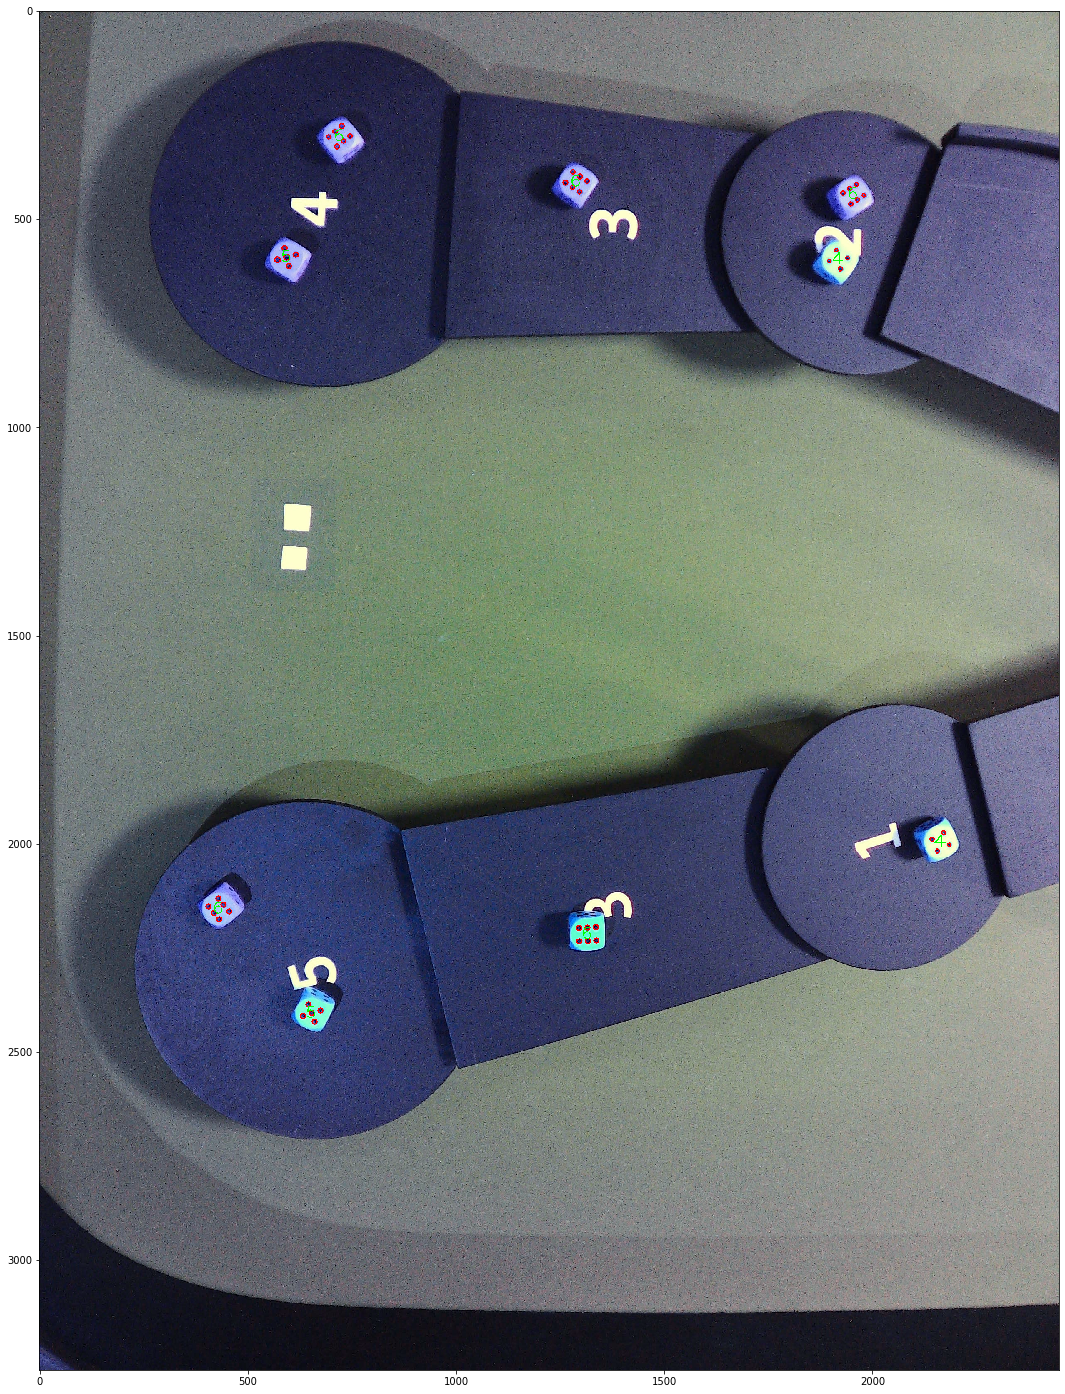

In [14]:

ax = plt.figure(figsize = (25,25))
plt.imshow(frame)


In [15]:

frame = cv2.imread(path)

In [16]:
def unique_count_app(a): # calculating the dominant color
    colors, count = np.unique(a.reshape(-1,a.shape[-1]), axis=0, return_counts=True)
    return colors[count.argmax()]

In [17]:
dice_pandas = pd.DataFrame(dice, columns = {'0', 'x', 'y'})

In [18]:
TARGET_COLORS = {"Red": (255,0,0), "Yellow": (255,255,0)}# target colors 
def color_difference (color1, color2):
    return sum([abs(component1-component2) for component1, component2 in zip(color1, color2)])


In [19]:
frame = cv2.imread(path)

In [20]:
def get_colors(dices, frame):# function for calculating the color
    img = cv2.imread(frame)

    croper_range = 45
    color_names = []
    
    dice_pandas = pd.DataFrame(dices, columns = {'0', 'x', 'y'})
    for index,row in dice_pandas.iterrows():
        crop_img = img[int(row['y']-40):int(row['y']+40), int(row['x']-40):int(row['x']+40)]
        crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
        hsvImg = cv2.cvtColor(crop_img,cv2.COLOR_BGR2HSV)
        hsvImg[...,1] = hsvImg[...,1]*1.2#making the image brighter than it is to classify the colro better
        hsvImg[...,2] = hsvImg[...,2]*1.7
        crop_img=cv2.cvtColor(hsvImg,cv2.COLOR_HSV2BGR)
        color_num= unique_count_app(crop_img)
        my_color = color_num
        differences = [[color_difference(my_color, target_value), target_name] for target_name, target_value in TARGET_COLORS.items()]
        differences.sort()  # sorted by the first element of inner lists
        my_color_name = differences[0][1]
        color_names.append(my_color_name)

    return color_names
        

In [21]:
colors = get_colors(dice,path)

In [22]:
color_df = pd.DataFrame(colors, columns={'color'})

In [23]:
dice_df = pd.DataFrame(dice, columns={'number', 'x', 'y'})

In [24]:
final = pd.merge(dice_df, color_df, left_index=True, right_index=True)
final.columns = ['number', 'x','y', 'color']

In [25]:
end = final.groupby('color').agg({'number': 'sum'})

In [26]:
dicti = end.to_dict()

In [27]:
end=  dicti.pop('number', None)

In [28]:
results =  print(end)# final colors

{'Red': 29, 'Yellow': 19}


In [29]:
def overlay_info(frame, dice, blobs, end_results):
 #   frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Overlay blobs
    cv2.putText(frame, str(end), (70,50),cv2.FONT_HERSHEY_TRIPLEX, #font family
      1.8, #font size
     (255, 0, 0,), #font color
     3) 
               
    for b in blobs:
        pos = b.pt
        r = b.size / 2

        cv2.circle(frame, (int(pos[0]), int(pos[1])),
                   int(r), (255, 0, 0), 2)

    # Overlay dice number
    for d in dice:
        # Get textsize for text centering
        textsize = cv2.getTextSize(
            str(d[0]), cv2.FONT_HERSHEY_PLAIN, 3, 2)[0]

        cv2.putText(frame, str(d[0]),
                    (int(d[1] - textsize[0] / 2),
                     int(d[2] + textsize[1] / 2)),
                    cv2.FONT_HERSHEY_PLAIN, 3, (0, 255, 0), 2)
        

        
    

In [30]:
overlay_info(frame,dice,blobs, end)

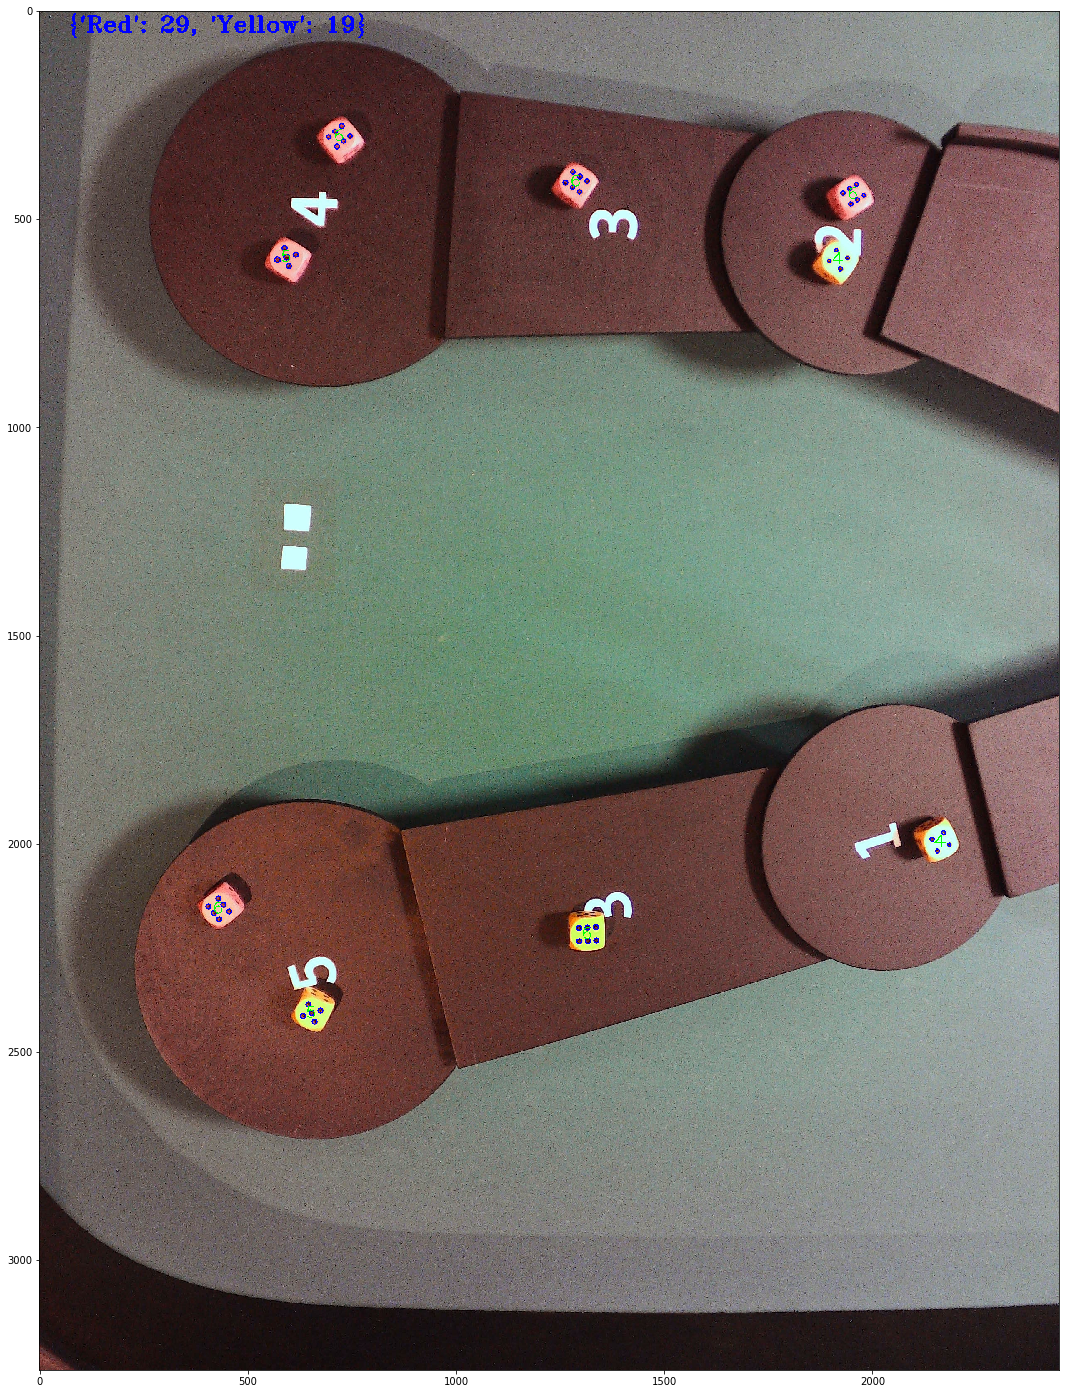

In [31]:

ax = plt.figure(figsize = (25,25))
frame =  cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)


In [2]:
import os, cv2
template = os.path.join(cv2.__path__[0], 'templates', 'temp_file')

In [3]:
template

'/opt/anaconda3/lib/python3.7/site-packages/cv2/templates/temp_file'